In [7]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser, PDBIO, Superimposer
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Modules fix_pdb.py and optimize_ligand.py also support command line interface
from fix_pdb import fix_pdb
from optimize_ligand import optimize_ligand
from lsalign_tools import extract_aligned_ligand, get_alignment_report


warnings.simplefilter('ignore', PDBConstructionWarning)

### Setting up and creating working directories

In [15]:
PROTEIN_PDB = "./input/2xp2.pdb"         # Complex of the studied protein
LIGANDS_DIR = "./input/ligands/set_1/"   # Directory with query ligands

INTERMEDIATE_DIR = "./intermediate_results/"
ENERGY_GRID_DIR = f"{INTERMEDIATE_DIR}energy_grid_maps/"
OUTPUT_DIR = "./output/"
LOG_DIR = "./logs/"


dirs_to_create = (
    f'{OUTPUT_DIR}docked_ligands',
    f'{OUTPUT_DIR}filtered_docked_poses',
    f'{OUTPUT_DIR}reports',
    f'{INTERMEDIATE_DIR}ligands',
    f'{ENERGY_GRID_DIR}AutoDock'
)

for _dir in dirs_to_create:
    !mkdir -p $_dir

### Functions of the main metrics

In [4]:
def compute_RMSD(target, queries, ignore_hydrogens=True):
    '''
    Computes RMSD between taeget and every query structure.

    Parameters
    ----------
    target : Bio.PDB.Structure.Structure
        Target structure.
    queries : Bio.PDB.Structure.Structure
        Query structures (may content multiple models).
    ignore_hydrogens: bool, optional
        To take into account or not the hydrogen atoms.
        The default is False wich means skip hydrogens.

    Returns
    -------
    RMSD : dict
        RMSD for each query model.
    '''
    target_atoms = next(target.get_residues())    
    RMSD = {}
    for model in queries:
        query_atoms = next(model.get_residues())
        rmsd = 0
        atom_counter = 0
        for atom in target_atoms:
            if ignore_hydrogens and atom.element == 'H':
                continue
            t, q = atom.get_coord(), query_atoms[atom.get_name()].get_coord()
            rmsd += ((t - q)**2).sum()
            atom_counter += 1
            
        RMSD[model.get_id()] = (rmsd / atom_counter)**0.5
        
    return RMSD


def compute_rotation_trace(target, queries, ignore_hydrogens=True):
    '''
    Computes rotation trace between taeget and every query structure.
    Rotation trace may be considered as measure of angle between 
    structures.

    Parameters
    ----------
    target : Bio.PDB.Structure.Structure
        Target structure.
    queries : Bio.PDB.Structure.Structure
        Query structures (may content multiple models).
    ignore_hydrogens: bool, optional
        To take into account or not the hydrogen atoms.
        The default is False wich means skip hydrogens.

    Returns
    -------
    rotation : dict
        Rotation trace for each query model.
    '''
    target_atoms = sorted(atom for atom in target.get_atoms() if atom.element != 'H')
    sup = Superimposer()
    rotation = {}
    for model in queries:
        query_atoms = sorted(atom for atom in model.get_atoms() if atom.element != 'H')
        sup.set_atoms(target_atoms, query_atoms)
        rotation[model.get_id()] = abs(np.trace(sup.rotran[0]))
    
    return rotation

## Preparation of protein model end energy grid

In [5]:
protein = os.path.basename(PROTEIN_PDB)

# Fixing protein structure and extracting native ligand
!./build_model \
    -f    $f'{PROTEIN_PDB}' \
    -oref $f'{INTERMEDIATE_DIR}{protein.rstrip('.pdb')}_ligand_reference.pdb' \
    -omm  $f'{INTERMEDIATE_DIR}corrected_{protein}' \
  
# # Checking Protein Structure for Potential Problems 
# # SUPRESSED! (Duplicates the functionality of the previous command)
# !./leadfinder \
#     --check-only \
#     --protein $f'{INTERMEDIATE_DIR}corrected_{protein}'

# Creating and Saving Energy Grid Maps
!./leadfinder \
    --grid-only \
    --save-grid        $f'{ENERGY_GRID_DIR}{protein.rstrip('.pdb')}_energy_grid_map.bin' \
    --protein          $f'{INTERMEDIATE_DIR}corrected_{protein}' \
    --ligand-reference $f'{INTERMEDIATE_DIR}{protein.rstrip('.pdb')}_ligand_reference.pdb'

# Converting Energy Grid to AutoDock map format
!./leadfinder \
    --grid-only \
    --load-grid $f'{ENERGY_GRID_DIR}{protein.rstrip('.pdb')}_energy_grid_map.bin' \
    --save-grid $f'{ENERGY_GRID_DIR}AutoDock/{protein.rstrip('.pdb')}_energy_grid_map.map'

## Docking and evaluation of ligands positions

In [8]:
# Preparation of the native ligand for alignment 
!obabel \
    $f'{INTERMEDIATE_DIR}{protein.rstrip('.pdb')}_ligand_reference.pdb' \
    -O $f'{INTERMEDIATE_DIR}{protein.rstrip('.pdb')}_ligand_reference.mol2'

# Ligands processing
docking_poses_evaluation = {}
ligands = sorted(ligand for ligand in os.listdir(LIGANDS_DIR) if ligand.endswith('.mol'))
for ligand_mol in ligands:
    print('Processing: ', ligand_mol)
    ligand = ligand_mol.rstrip('.mol')
    
    # Docking
    optimize_ligand(f'{LIGANDS_DIR}{ligand_mol}', f'{INTERMEDIATE_DIR}ligands/{ligand}.pdb')
    
    !./leadfinder \
        --load-grid $f'{ENERGY_GRID_DIR}{protein.rstrip('.pdb')}_energy_grid_map.bin' \
        --ligand $f'{INTERMEDIATE_DIR}ligands/{ligand}.pdb' \
        --output-poses $f'{OUTPUT_DIR}docked_ligands/{ligand}_docking_poses.pdb' \
        --text-report $f'{OUTPUT_DIR}reports/{ligand}_docking_report.txt'
    
    # Fixing docking output
    fix_pdb(f'{INTERMEDIATE_DIR}ligands/{ligand}.pdb', 
            f'{OUTPUT_DIR}docked_ligands/{ligand}_docking_poses.pdb')
    
    
    # Alignment of the considered ligand with native ligand using LSalign software
    # https://doi.org/10.1093/bioinformatics/bty081
    !obabel $f'{LIGANDS_DIR}{ligand_mol}' -O $f'{INTERMEDIATE_DIR}ligands/{ligand}.mol2'

    !LSalign \
        $f'{INTERMEDIATE_DIR}ligands/{ligand}.mol2' \
        $f'{INTERMEDIATE_DIR}{protein.rstrip(".pdb")}_ligand_reference.mol2' \
        -m $f'{INTERMEDIATE_DIR}ligands/{ligand}_translation_matrix.txt' \
        -a $f'{INTERMEDIATE_DIR}ligands/{ligand}_alignment_information.txt' \
        -o $f'{INTERMEDIATE_DIR}ligands/{ligand}_alignment.pdb' \
        -rf 1 -md 1 -acc 0 \
        > $f'{INTERMEDIATE_DIR}ligands/{ligand}_alignment_report.txt'
    
    extract_aligned_ligand(f'{INTERMEDIATE_DIR}ligands/{ligand}.pdb',
                           f'{INTERMEDIATE_DIR}ligands/{ligand}_alignment.pdb',
                           f'{INTERMEDIATE_DIR}ligands/{ligand}_rotated.pdb')
    
    
    # Evaluation of the similarity of the ligand positions with the original structure
    parser = PDBParser()
    ligand_structure = parser.get_structure('ligand', f'{INTERMEDIATE_DIR}ligands/{ligand}_rotated.pdb')
    docked_positions = parser.get_structure('docked', f'{OUTPUT_DIR}docked_ligands/{ligand}_docking_poses.pdb')

    # Not working because of LSalign translation matrix generating bug! 
    # Using extract_aligned_ligand instead.
    ##########################################################################################
    # M = get_translation_matrix(f'{INTERMEDIATE_DIR}ligands/{ligand}_translation_matrix.txt')
    # for atom in ligand_structure.get_atoms():
    #     # atom.transform(M, T)

    # io = PDBIO()
    # io.set_structure(ligand_structure)
    # io.save(f'{INTERMEDIATE_DIR}ligands/{ligand}_rotated.pdb')
    ##########################################################################################
        
    docking_poses_evaluation[ligand] = {
        'alignment_report': get_alignment_report(f'{INTERMEDIATE_DIR}ligands/{ligand}_alignment_report.txt'),
        'RMSD': sorted(compute_RMSD(ligand_structure, docked_positions).items(), key=lambda x: x[1]),
        'rotation': sorted(compute_rotation_trace(ligand_structure, docked_positions).items(), key=lambda x: x[1])
    }

Processing:  1a.mol
Processing:  1b.mol
Processing:  1c.mol
Processing:  1d.mol
Processing:  1e.mol
Processing:  1f.mol
Processing:  2a.mol
Processing:  2b.mol
Processing:  2c.mol
Processing:  3a.mol
Processing:  3b.mol
Processing:  3c.mol
Processing:  3d.mol
Processing:  3e.mol
Processing:  3f.mol
Processing:  3g.mol
Processing:  3h.mol
Processing:  3i.mol
Processing:  3j.mol


## Plotting the similarity of query ligand positions with a naive ligand

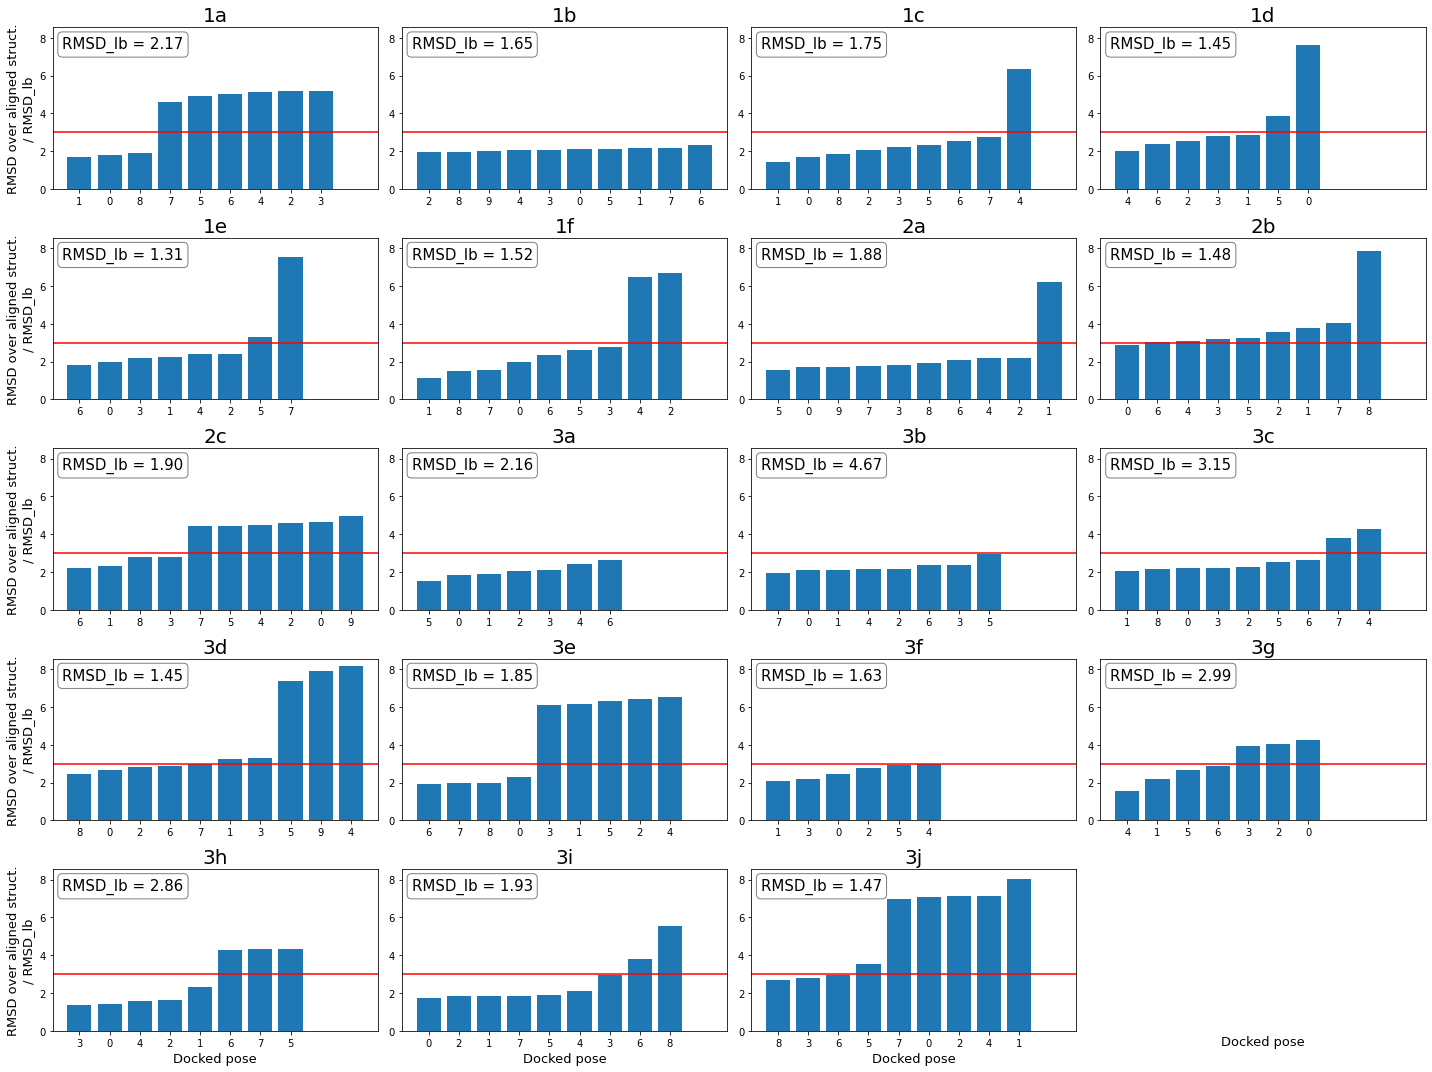

In [24]:
N_COLS = 4
TILE_WIDTH = 5
TILE_HIGHT = 3
THRESHOLD = 3    # Take a look at the charts and set this parameter to see discarded models

n_ligands = len(docking_poses_evaluation)
n_rows = n_ligands // N_COLS + bool(n_ligands % N_COLS)

fig, axes = plt.subplots(n_rows, N_COLS, figsize=(TILE_WIDTH * N_COLS, TILE_HIGHT * n_rows))

docking_poses_evaluation_iter = iter(sorted(docking_poses_evaluation.items()))
y_limit = (0, 0)
x_limit = (0, 0)
i = 0
for ax in axes.flatten():
    if i >= (n_rows - 1)*N_COLS:
        ax.set_xlabel('Docked pose', fontsize=13)
    if not i % N_COLS:
        ax.set_ylabel('RMSD over aligned struct.\n/ RMSD_lb', fontsize=13)
        
    try:
        ligand, metrics = next(docking_poses_evaluation_iter)
    except StopIteration:
        # ax.set_axis_off()
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        continue
    
    ax.set_title(ligand, fontsize=20)
    
    RMSD_lb = metrics['alignment_report']['RMSD_lb']
    box = dict(boxstyle='round', facecolor='w', alpha=0.5)
    ax.text(0.03, 0.87, f'RMSD_lb = {RMSD_lb:.2f}', 
            fontsize=15, transform=ax.transAxes, bbox=box)
    
    RMSD, rotation = metrics['RMSD'], metrics['rotation']
    
    n = len(RMSD)
    docking_poses = (str(record[0]) for record in RMSD)
    docking_rmsd = tuple(record[1] / RMSD_lb for record in RMSD)
    ax.bar(range(n), docking_rmsd)
    ax.set_xticks(range(n))
    ax.set_xticklabels(docking_poses)
    
    ax.axhline(THRESHOLD, color='r')
    
    y_limit = max(y_limit, ax.get_ylim())
    x_limit = max(x_limit, ax.get_xlim(), key=lambda x: x[1])
    i += 1

for ax in axes.flatten():
    ax.set_ylim(y_limit)
    ax.set_xlim(x_limit)
    
plt.tight_layout()

The graphs for each position of each ligand show the metric RMSD / RMSD_lb, where
- RMSD is a root mean square error between current position and position aligned with native legend by LSalign tool.
- RMSD_lb is a metric for the quality of alignment obtained using LSalign (for more information, see the documentation). RMSD_lb stands in the denominator because with a low quality of alignment of the ligand with the native one, the metric becomes less representative and the exclusion criterion should be more conservative.

The red line indicates the threshold exceeding which leads to the exclusion of the model from consideration. The threshold is set manually after visual analysis of the graphs.

## Exclusion of inadequate docking positions

In [25]:
for ligand_mol in ligands:
    ligand = ligand_mol.rstrip('.mol')   
    
    RMSD_lb = docking_poses_evaluation[ligand]['alignment_report']['RMSD_lb']
    bad_models = [model[0] for model in docking_poses_evaluation[ligand]['RMSD'] if model[1] / RMSD_lb > THRESHOLD]
    
    parser = PDBParser()
    docked_positions = parser.get_structure('docked', f'{OUTPUT_DIR}docked_ligands/{ligand}_docking_poses.pdb')
    for model in bad_models:
        del docked_positions[model]
        
    io = PDBIO()
    io.set_structure(docked_positions)
    io.save(f'{OUTPUT_DIR}filtered_docked_poses/{ligand}_filtered_docking_poses.pdb')